# Final Capstone Notebook 2 out of 4

See notebook 1 for the text cleaning phase of this project. For this notebook, our objective is to create a sentiment classifier using the star ratings as the target variable. We will be running different supervised and deep learning models to determine which ones are the best. After selecting the best models, we will perform a GridSearch to optimize the models.

The goal is to create a sentiment classifier that can predict the sentiment of reviews and comments for restaurants in Cleveland, Ohio. Ultimately, this is useful because we can use it on unlabelled reviews such as Facebook reviews or Twitter tweets. If we can predict the sentiment of various media platforms, it would help restaurants make marketing decisions. For example, we can see if sentiment changes over time after a major marketing campaign or a change in management. We can also see if certain media platforms are more favorable for marketing than others.

In [1]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)

# Code to save model into Google Drive:
import pickle
from google.colab import drive
drive.mount('/content/gdrive')

# Basic libraries
import numpy as np
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
sns.set(style="whitegrid")

from collections import Counter
from functools import partial
from IPython.core.display import HTML
from joblib import dump

# Supervised learning models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Deep neutral networks
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

!pip install simpletransformers
from simpletransformers.classification import ClassificationModel

# Text manipulation tools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Remove column width so we can read entire text
pd.set_option('display.max_colwidth', 0)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 194kB 5.0MB/s 
     |████████████████████████████████| 665kB 16.5MB/s 
     |████████████████████████████████| 204kB 27.4MB/s 
     |████████████████████████████████| 3.8MB 27.8MB/s 
     |████████████████████████████████| 1.1MB 30.2MB/s 
     |████████████████████████████████| 890kB 41.1MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=cf8037f240da923f3af10b41c8a633fca61b3ad32d54819df7ffb7639b152c58
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=a618aa46902460a7e6e769a61a086ed707cb61bcb8b54958b5dae709e7c54595
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built seqeval sacremoses


# Load Dataset

Because the lemmatizer removes words, we will have cells with no text. This could be due to the fact that all the words in some reviews or tips were stopwords or CJK characters. We will simply remove these reviews and tips.

In [0]:
# Pull from Google Drive
downloaded = gdrive.CreateFile({'id':'1jgK8n9-vHNgtU-JHiNN-vkhGJgkcpulR'})
downloaded.GetContentFile('yelp_reviews_lem.csv') 

downloaded = gdrive.CreateFile({'id':'1ZQJ3NSHEy4QARk2XN_sSYTk0FiJqfIE_'})
downloaded.GetContentFile('yelp_tips_lem.csv')

In [3]:
# Read files as df
df = pd.read_csv('yelp_reviews_lem.csv') 
df.head(2)

,business_id,stars,date,text,useful,funny,cool,name,review_count,lem_join
0,meXjqyhTNLFmknY39y2sMg,5,2014-09-11,"Solid beers -- Christmas Ale defines my holiday season. I moved away a long time ago, but whenever I am home, I try to make a stop at Great Lakes. Great vibe, super chill, stellar food and beer.",1,1,1,"""Great Lakes Brewing Company""",751,solid beer christmas ale define holiday season away long time ago home try stop great lakes great vibe super chill stellar food beer
1,meXjqyhTNLFmknY39y2sMg,3,2013-10-13,"Meh. It was OK. A bartender the night before somewhere told us that while we were in Cleveland we HAD to eat here, so we took her advice and grabbed an early dinner here after spending the day at the Rock N Roll Hall of Fame. Like I said, it was alright. We had 3 different servers through the meal (dont know what ANY of their names were, and was never told that someone else would be taking care of us... all the sudden, someone else just started coming to our table). The first server suggested the pizza because it was half off, so we both had one.. they were decent, but not something that I think I would have suggested to anyone, and definitely not something I would order again. Not that they were BAD, but I think (or I hope..) they have better choices. We originally ordered a beer flight of all 6 specialty beers, and I didn't like any of them (not because they weren't good beers, I'm sure they were, but for someone who isn't a big beer drinker- it was a no go), so my husband just drank all of them, and when I ordered a soda, our SECOND server laughed at me. 'Nuff said, I think. Anyway, it was an experience, and we both like trying new places, especially local spots, so I'm glad we went. It just wasn't the amazing time we were expecting based on what we had been told. And to be fair, maybe all of that isn't normal- sometimes things happen and you just draw the short straw. But we weren't super impressed.\n\nGood gift shop, though. They sell most of the specialty beers in the shop and you can make your own six packs of whatever you want. Plus they have some nice merchandise to choose from, too.",0,1,0,"""Great Lakes Brewing Company""",751,meh ok bartender night tell cleveland eat advice grab early dinner spend day rock n roll hall fame like alright 3 different server meal do not know never tell else care sudden else start come table server suggest pizza half decent not think suggest definitely not order not bad think hope well choice originally order beer flight 6 specialty beer do not like not not good beer sure not big beer drinker- no go husband drink order soda second server laugh nuff think experience like try new place especially local spot glad go not amazing time expect base tell fair maybe not normal- thing happen draw short straw not super impressed \n\n good gift shop sell specialty beer shop pack want plus nice merchandise choose


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56910 entries, 0 to 56909
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   business_id   56910 non-null  object
 1   stars         56910 non-null  int64 
 2   date          56910 non-null  object
 3   text          56910 non-null  object
 4   useful        56910 non-null  int64 
 5   funny         56910 non-null  int64 
 6   cool          56910 non-null  int64 
 7   name          56910 non-null  object
 8   review_count  56910 non-null  int64 
 9   lem_join      56906 non-null  object
dtypes: int64(5), object(5)
memory usage: 4.3+ MB


In [5]:
# Read files as df
tips = pd.read_csv('yelp_tips_lem.csv')
tips.head()

,text,date,likes,business_id,lem_join,name
0,"The Cleveland Pickle is the best sandwich deli ever! Hands down! Unique, fresh, delicious, creative! Amazing! Can't wait to go back!",2012-10-20,0,MTsIckdo3_uKuqk3B4zuKA,cleveland pickle good sandwich deli hand unique fresh delicious creative amazing not wait go,"""Cleveland Pickle"""
1,A bit different. Out at a restaurant for Thanksgiving. Buffet looks yummy.,2010-11-25,0,0youcKV6-eE3F2MQj1l6Fw,bit different restaurant thanksgiving buffet look yummy,"""100th Bomb Group"""
2,Tab Benoit,2012-08-10,0,CDqPVVvQtVncNQGydnZy7A,tab benoit,"""Beachland Ballroom and Tavern"""
3,One of the. Eat buffet I have been to in an very long time,2016-10-28,0,pGjtxXBq4tZcdKdgTU-Tww,eat buffet long time,"""Little Hong Kong"""
4,Shipwreck! That's an awesome breakfast!,2010-09-11,0,_5PJ4GHIXNdUdXtohylKGQ,shipwreck awesome breakfast,"""Lucky's Café"""


In [6]:
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10107 entries, 0 to 10106
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         10107 non-null  object
 1   date         10107 non-null  object
 2   likes        10107 non-null  int64 
 3   business_id  10107 non-null  object
 4   lem_join     10082 non-null  object
 5   name         10107 non-null  object
dtypes: int64(1), object(5)
memory usage: 473.9+ KB


These are the phrases that were lemmatized but didn't produce any output.

In [7]:
df[df['lem_join'].isnull()]

,business_id,stars,date,text,useful,funny,cool,name,review_count,lem_join
34130,Tm2dKN_-DCdZfF2xMWrX7w,4,2015-07-08,如果你看得懂中文，這裏是個好地方。基本所有點的菜都挺不錯。80分。服務欣勤，態度不錯,1,0,0,"""Siam Cafe""",187,NaN
36108,ZedwJdX1jQ7Hw1CzU3VDLw,5,2017-06-28,這裡的現烤pizza 很好吃，gelato也很好吃也有很多口味，老闆很親切，服務生也很熱情，絕對推薦要來小義大利的人一定要來吃喔!,0,0,0,"""La Pizzeria""",39,NaN
47581,97V91GSG-OQvrvOc9GXoGA,5,2016-07-10,如果是台灣的朋友看到這篇留言，不要猶豫了一定要去！完全的台灣味，吃了會想哭，一百分的服務和餐點，份量完全飽，但是烹調不馬虎非常用心製作，謝謝老闆和lala給我們一個美好的晚餐，這是我們在美國吃到最好吃的東西，我永遠不會忘記的！,0,0,0,"""Phusion Cafe""",128,NaN
47678,97V91GSG-OQvrvOc9GXoGA,5,2016-07-10,在美國吃過最美好的一餐，老闆人真的好好，果然還是台灣食物最美好了!一定會再回去，溫馨的感覺，在異地吃到好吃的家鄉菜怎麼能不感動!大推,0,0,0,"""Phusion Cafe""",128,NaN


In [8]:
tips[tips['lem_join'].isnull()].head()

,text,date,likes,business_id,lem_join,name
1166,I'm,2016-11-05,0,eoJfl5vG7X87QhcKb0nt5Q,NaN,"""Hofbrauhaus Cleveland"""
1642,Get some!,2014-04-10,0,8hwbcCNUv345Kw1xfOCcWg,NaN,"""Brown Derby"""
2317,What????!,2011-11-05,0,Ya9FMj-MWMkeMcog06N5bQ,NaN,"""Bar Louie"""
3077,:),2013-05-17,0,gNER9lE1Ma9FLm9MBsvYgg,NaN,"""Market Garden Brewery"""
3467,A must see,2011-03-20,0,9_0FtoabuC42T7AWDk5_sA,NaN,"""Algebra Tea House"""


In [0]:
# Remove them
df.dropna(inplace=True)
tips.dropna(inplace=True)

# Explore the data at the surface

By looking at the star ratings, we can that stars are negatively skewed. There are more 4 and 5 star reviews then 1, 2, & 3 star reviews. As a result, we may have a model that is better at predicting positive reviews then negative reviews. 

We can also see that no matter what star review, the lengths of the reviews do not change much. People do not give additional insight for good or bad service. As a result, it can be very hard to distinguish between 1, 2 or 3 star reviews. We will also have a hard time distinguishing between 4 and 5 star reviews. 

I seems that xkcd had the right [idea](https://xkcd.com/1098/) about yelp reviews. As a result, it would be best to divide the reviews into "bad" (1, 2, & 3 stars) & "good" reviews (4 & 5 stars). 

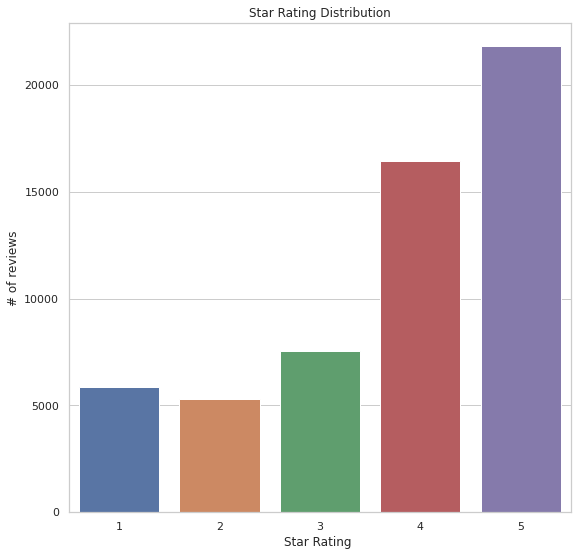

In [10]:
plt.figure(figsize=(9,9))
sns.countplot(x='stars', data=df)
plt.ylabel('# of reviews')
plt.xlabel('Star Rating ')
plt.title("Star Rating Distribution");

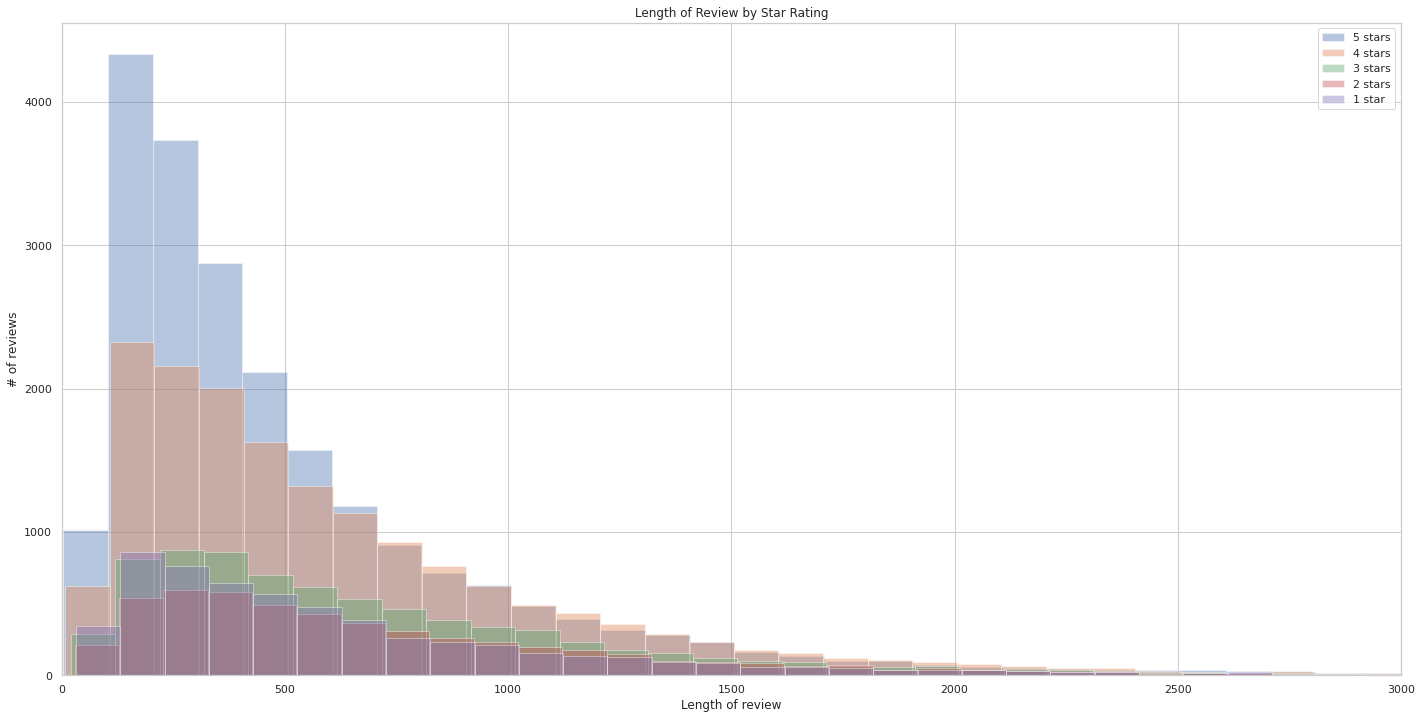

In [11]:
# Compare lengths of reviews by star rating
df['length'] = df['text'].apply(lambda x: len(x))

plt.figure(figsize=(24,12))
sns.distplot(df[df.stars==5].length, kde=False, label='5 stars')
sns.distplot(df[df.stars==4].length, kde=False, label='4 stars')
sns.distplot(df[df.stars==3].length, kde=False, label='3 stars')
sns.distplot(df[df.stars==2].length, kde=False, label='2 stars')
sns.distplot(df[df.stars==1].length, kde=False, label='1 star')

plt.ylabel('# of reviews')
plt.xlabel('Length of review')
plt.xlim(0, 3000)
plt.title("Length of Review by Star Rating")
plt.legend();

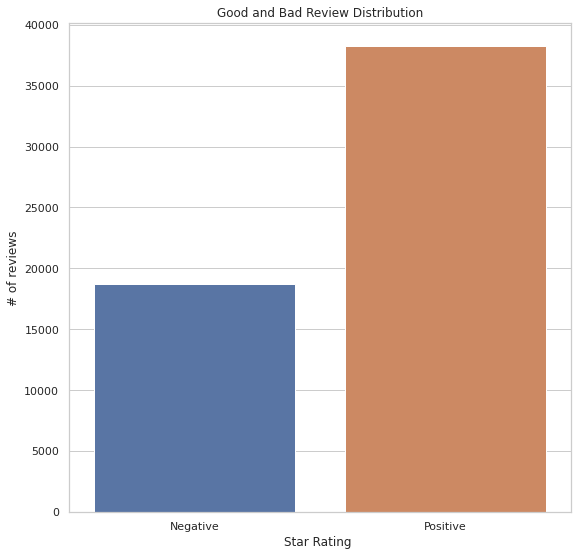

In [12]:
# Create the target variable
df['target'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0)

plt.figure(figsize=(9,9))
sns.countplot(x='target', data=df)
plt.ylabel('# of reviews')
plt.xlabel('Star Rating ')
plt.xticks([0, 1], ['Negative', 'Positive']) 
plt.title("Good and Bad Review Distribution");

When looking at the wordclouds below, we can see that common words will show up in most of the reviews ('food', 'order', 'go', 'place'). Not surprisingly, the food is the most common topic of focus for good and bad reviews.

However, we do see that 'time' shows up more as the reviews get lower. This could be in reference to wait times. We also see 'waitress' and 'service' shows up more in lower reviews than in higher ones. This suggests that bad service and long wait times are more noticeable than good and timely service. The word 'bad' only really starts to show up in 1-star reviews. This suggests that reviews for adequate and good experiences range from 2 to 5 stars.

Words like 'great', 'awesome', 'delicious' tend to dominate 5 star reviews. 'Good' will show up but decreases in frequency as the stars get lower. This may suggest that food drives positive reviews more than anything. The word 'Cleveland' shows up in 4 and 5 star reviews suggesting that these places are local favorites (i.e. "Best burgers in all of Cleveland!").


CPU times: user 27.4 s, sys: 973 ms, total: 28.4 s
Wall time: 28.3 s


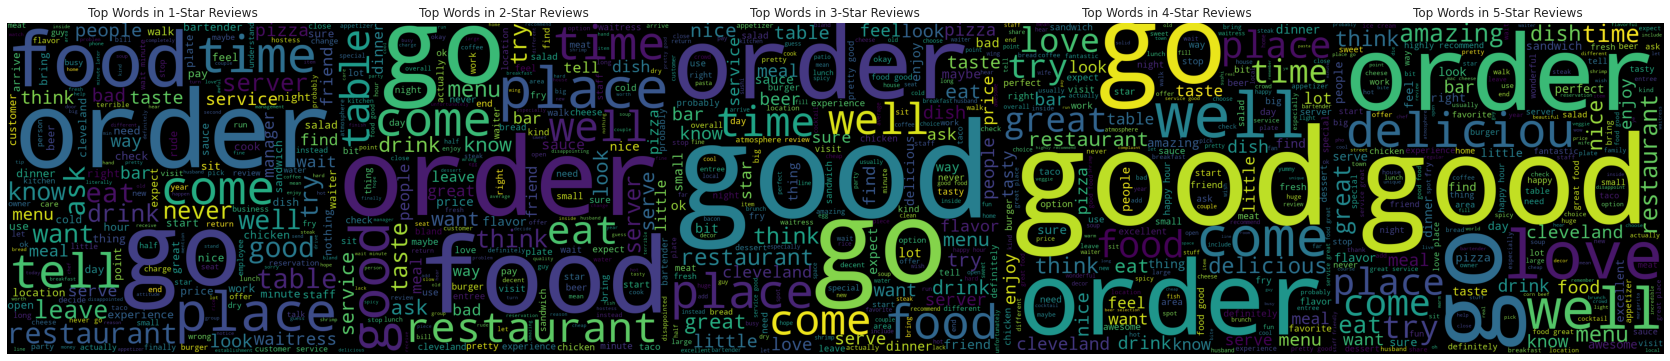

In [13]:
%%time
# Set up plot
plt.figure(figsize = (23, 115), facecolor = None)

for star in range(1,6):
  star_words = ''
  
  # Create string of words
  for review in df[df.stars == star].lem_join:
    star_words += review + " " 
  
  # Prep wordcloud reviews
  wordcloud = WordCloud(width = 800, 
                        height = 800, 
                        background_color ='black', 
                        min_font_size = 10).generate(star_words)    

  # Plot the WordCloud image                        
  plt.subplot(1, 5, star) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  plt.title(f"Top Words in {star}-Star Reviews");

# Text Extraction

We will be using tf-idf and bag of words to prep the text. The tf-idf vectorizer is an alternative to bag of words as it reduces weighting of common words that show up in all reviews like "good", "food", etc. and will try to add weight to words that are unique to each category. 

For tf-idf, we will try single words and bigrams. Bigrams allow us to capture important word combos like "chicken salad", "happy hour" & "waiting time"

## Train-test split the data

We will split the data twice. We will first split the data between the train and test set. Then we will split the data again into the small training set and validation set. The small training set will be used to calculate the cross-validation score. The validation set will be used when calculating the confusion matrices,the classification reports, and the AUC curves. The final model will be trained with the entire train set, and the tested with the test set.

Note that we will NOT be using this layout when we test the DistilBERT model. Because we cannot use the Scitkit-Learn cross_val function, we will have to manually perform a K-fold cross-validation run. Each fold will make a validation set from the entire training set each time. The predictions for all the folds will then be averaged out.

In [0]:
# Declare X & Y
Y = df['target']
X = df['lem_join']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42, stratify=Y
)

# Training-Validation split
X_train_sm, X_val, y_train_sm, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

## Prep BoW

In [0]:
# Get the top 2000 words
n_top_words = 2000
count_vec = CountVectorizer(max_features=n_top_words)

In [0]:
# Apply to X values
X_train_bow = count_vec.fit_transform(X_train)
X_test_bow = count_vec.transform(X_test)

X_train_sm_bow = count_vec.fit_transform(X_train_sm)
X_val_bow = count_vec.transform(X_val)

## Prep Tf-Idf

In [0]:
tfidf_vec = TfidfVectorizer(
    max_df=0.5, 
    min_df=2,
    stop_words='english', 
    lowercase=True,
    use_idf=True,
    norm=u'l2',
    smooth_idf=True, 
    ngram_range = (1,2)
)

In [0]:
# Applying to X values
X_train_tfidf=tfidf_vec.fit_transform(X_train)
X_test_tfidf=tfidf_vec.transform(X_test)

X_train_sm_tfidf=tfidf_vec.fit_transform(X_train_sm)
X_val_tfidf=tfidf_vec.transform(X_val)

# Phase 1a: Choosing model for sentiment analysis

We will be using 3 supervised models (Logistic Regression, Naive Bayes, &  Stochastic Gradient Descent) and 2 deep learning models (KERAS and DistilBERT). Although deep learning models are very powerful, they often require a great deal of data and are very expensive to run. If we can get a good enough score using simpler models, it may be preferable.

In [0]:
# Used when you have a validation set to work with
def model_metrics(model, X, y, X_val, y_val):
    model_sum = {}
    
    # Get cross validation score & mean of CV score
    cv_score = cross_val_score(model, X, y, cv=10, n_jobs=-1)
    
    model_sum['cv_scores'] = list(cv_score)
    model_sum['cv_mean'] = np.mean(cv_score)
    
    # Get confusion matrix metrics
    y_pred = model.predict(X_val)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    
    model_sum['true negatives'] = tn
    model_sum['false positives'] = fp
    model_sum['false negatives'] = fn
    model_sum['true positives'] = tp
    model_sum['accuracy'] = (tp+tn)/len(y_pred)
    model_sum['f1 score'] = 2*tp/(2*tp+fp+fn)
    model_sum['class_report'] = classification_report(y_val, y_pred)
    
    return model_sum

In [0]:
# Used when you do not have a validation set to work with
def model_metrics2(model, X, y):
    model_sum = {}
    
    # Get cross validation score & mean of CV score
    cv_score = cross_val_score(model, X, y, cv=10, n_jobs=-1)
    
    model_sum['cv_scores'] = list(cv_score)
    model_sum['cv_mean'] = np.mean(cv_score)
    
    # Get confusion matrix metrics
    y_pred = model.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    model_sum['true negatives'] = tn
    model_sum['false positives'] = fp
    model_sum['false negatives'] = fn
    model_sum['true positives'] = tp
    model_sum['accuracy'] = (tp+tn)/len(y_pred)
    model_sum['f1 score'] = 2*tp/(2*tp+fp+fn)
    model_sum['class_report'] = classification_report(y, y_pred)
    
    return model_sum

In [0]:
def format_metrics(model_sum):
    # Print cross-validation scores
    print("Cross Validation Scores Using Small Training Set\n" + 48*"=" + 
          "\n{}\n".format(model_sum['cv_scores']))
    print("Average CV = {}\n".format(model_sum['cv_mean']))
    
    # Print classification report
    print("Classification Report Using Validation Set\n" + 42*"=" + 
          "\n" + model_sum['class_report'])
    
    # Print confusion matrix results
    print("Confusion Matrix Using Validation Set\n" + 37*"=" + 
          '\nTrue Positives = {}\nTrue Negatives'\
          '= {}\nFalse Positives = {}\nFalse Negatives = {}'\
          .format(model_sum['true positives'], 
                  model_sum['true negatives'], 
                  model_sum['false positives'], 
                  model_sum['false negatives']))

## Model 1: Logistic Regression

In [0]:
# Set parameters
params = {
    'penalty': 'l2',
    'fit_intercept': True, 
    'max_iter': 100, 
    'n_jobs':-1, 
    'dual': False
}

In [23]:
lrm_model1 = LogisticRegression(**params)
lrm_model2 = LogisticRegression(**params)

# Fit both models
lrm_model1.fit(X_train_sm_bow, y_train_sm)
lrm_model2.fit(X_train_sm_tfidf, y_train_sm)

# Prep and display metrics
lrm_results_bow = model_metrics(lrm_model1, X_train_sm_bow, 
                                y_train_sm, X_val_bow, y_val)
lrm_results_tfidf = model_metrics(lrm_model2, X_train_sm_tfidf, 
                                  y_train_sm, X_val_tfidf, y_val)

print('\nLogistic Regression Model (BoW)')
print('*'*31)
format_metrics(lrm_results_bow)

print('\n\nLogistic Regression Model (Tf-Idf)')
print('*'*34)
format_metrics(lrm_results_tfidf)


Logistic Regression Model (BoW)
*******************************
Cross Validation Scores Using Small Training Set
[0.8865174388339406, 0.8844051028378026, 0.8765946368133298, 0.8755532413434002, 0.8807602186930487, 0.8789377766206717, 0.8732101015360583, 0.8771153345482947, 0.8721687060661286, 0.8781567300182245]

Average CV = 0.8783419287310898

Classification Report Using Validation Set
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      1402
           1       0.89      0.93      0.91      2866

    accuracy                           0.88      4268
   macro avg       0.87      0.85      0.86      4268
weighted avg       0.88      0.88      0.88      4268

Confusion Matrix Using Validation Set
True Positives = 2677
True Negatives= 1069
False Positives = 333
False Negatives = 189


Logistic Regression Model (Tf-Idf)
**********************************
Cross Validation Scores Using Small Training Set
[0.8844351900052057, 0.884665451705

## Model 2: Naive Bayes Classifier

In [24]:
clf_model1 = MultinomialNB()
clf_model2 = MultinomialNB()

# Fit both models
clf_model1.fit(X_train_sm_bow, y_train_sm)
clf_model2.fit(X_train_sm_tfidf, y_train_sm)

# Prep and display metrics
clf_results_bow = model_metrics(clf_model1, X_train_sm_bow, 
                                y_train_sm, X_val_bow, y_val)
clf_results_tfidf = model_metrics(clf_model2, X_train_sm_tfidf, 
                                  y_train_sm, X_val_tfidf, y_val)

print('\nNaive Bayes Model (BoW)')
print('*'*23)
format_metrics(clf_results_bow)

print('\n\nNaive Bayes Model (Tf-Idf)')
print('*'*26)
format_metrics(clf_results_tfidf)


Naive Bayes Model (BoW)
***********************
Cross Validation Scores Using Small Training Set
[0.8636127017178553, 0.8674824264514449, 0.8635771934392086, 0.8555063785472533, 0.8588909138245249, 0.8625357979692788, 0.8536839364748763, 0.8557667274147357, 0.8570684717521478, 0.8620151002343139]

Average CV = 0.8600139647825639

Classification Report Using Validation Set
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1402
           1       0.87      0.91      0.89      2866

    accuracy                           0.85      4268
   macro avg       0.84      0.82      0.83      4268
weighted avg       0.85      0.85      0.85      4268

Confusion Matrix Using Validation Set
True Positives = 2617
True Negatives= 1028
False Positives = 374
False Negatives = 249


Naive Bayes Model (Tf-Idf)
**************************
Cross Validation Scores Using Small Training Set
[0.7816241540864133, 0.7841707888570685, 0.7737568341577714, 0.7805

## Model 3: Linear SGD Classifier

In [0]:
params = {
    'loss': 'log', 
    'penalty': 'l2', 
    'alpha': 1e-3, 
    'random_state': 42, 
    'max_iter': 5, 
    'tol': None
}

In [26]:
sgd_model1 = SGDClassifier(**params)
sgd_model2 = SGDClassifier(**params)

# Fit both models
sgd_model1.fit(X_train_sm_bow, y_train_sm)
sgd_model2.fit(X_train_sm_tfidf, y_train_sm)

# Prep and display metrics
sgd_results_bow = model_metrics(sgd_model1, X_train_sm_bow, 
                                y_train_sm, X_val_bow, y_val)
sgd_results_tfidf = model_metrics(sgd_model2, X_train_sm_tfidf, 
                                  y_train_sm, X_val_tfidf, y_val)

print('\nStochastic Gradient Descent Classification Model (BoW)')
print('*'*54)
format_metrics(sgd_results_bow)

print('\n\nStochastic Gradient Descent Classification Model (Tf-Idf)')
print('*'*57)
format_metrics(sgd_results_tfidf)


Stochastic Gradient Descent Classification Model (BoW)
******************************************************
Cross Validation Scores Using Small Training Set
[0.8854763144195731, 0.886487893777662, 0.877896381150742, 0.8755532413434002, 0.8771153345482947, 0.8812809164280135, 0.8698255662587868, 0.8799791720906014, 0.8734704504035408, 0.877896381150742]

Average CV = 0.8784981651571357

Classification Report Using Validation Set
              precision    recall  f1-score   support

           0       0.85      0.75      0.80      1402
           1       0.88      0.94      0.91      2866

    accuracy                           0.87      4268
   macro avg       0.87      0.84      0.85      4268
weighted avg       0.87      0.87      0.87      4268

Confusion Matrix Using Validation Set
True Positives = 2680
True Negatives= 1052
False Positives = 350
False Negatives = 186


Stochastic Gradient Descent Classification Model (Tf-Idf)
*****************************************************

## Model 4: Keras Classifier


In [0]:
# Used to create Keras model
def create_keras(X):
    input_dim = X.shape[1]
    model = Sequential()
    model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(36, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'], 
                  run_eagerly=True)
    return model

# Partial will always call the function with the designated input
bow_keras = partial(create_keras, X_train_sm_bow)
tfidf_keras = partial(create_keras, X_train_sm_tfidf)

In [28]:
# We will run each model separately due to memory issues
keras_model1 = KerasClassifier(
    build_fn=bow_keras, 
    epochs=10, 
    batch_size=1000, 
    verbose=0)

# Fit both models
keras_model1.fit(X_train_sm_bow, y_train_sm)

# Calculate results
keras_results_bow = model_metrics(keras_model1, X_train_sm_bow, 
                                  y_train_sm, X_val_bow, y_val)

keras_pred_bow = keras_model1.predict_proba(X_val_bow)[:,1]

# Delete model to save memory
del keras_model1
gc.collect()

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.


34333

In [29]:
keras_model2 = KerasClassifier(
    build_fn=tfidf_keras, 
    epochs=10, 
    batch_size=1000, 
    verbose=0)

# Fit both models
keras_model2.fit(X_train_sm_tfidf.sorted_indices(), y_train_sm)

# Calculate results
keras_results_tfidf = model_metrics(
    keras_model2, X_train_sm_tfidf.sorted_indices(), 
    y_train_sm, X_val_tfidf.sorted_indices(), y_val
    )

keras_pred_tfidf = keras_model2.predict_proba(
    X_val_tfidf.sorted_indices())[:,1] 

# Delete model to save memory
del keras_model2
gc.collect()

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


797

In [30]:
print('\nKERAS Classification Model (BoW)')
print('*'*32)
format_metrics(keras_results_bow)

print('\n\nKERAS Classification Model (Tf-Idf)')
print('*'*35)
format_metrics(keras_results_tfidf)


KERAS Classification Model (BoW)
********************************
Cross Validation Scores Using Small Training Set
[0.8862571716308594, 0.8612340688705444, 0.8661806583404541, 0.8617547750473022, 0.8677427768707275, 0.8640978932380676, 0.8516011238098145, 0.8646185994148254, 0.8609737157821655, 0.8646185994148254]

Average CV = 0.8649079382419587

Classification Report Using Validation Set
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1402
           1       0.89      0.92      0.91      2866

    accuracy                           0.87      4268
   macro avg       0.86      0.85      0.86      4268
weighted avg       0.87      0.87      0.87      4268

Confusion Matrix Using Validation Set
True Positives = 2642
True Negatives= 1092
False Positives = 310
False Negatives = 224


KERAS Classification Model (Tf-Idf)
***********************************
Cross Validation Scores Using Small Training Set
[0.8872982859611511, 0.88049989

## Model 5: DistilBERT Classifier

Because DistilBERT is very memory intensive, we have to reduce the sample size. This will hinder the overall performance, but we can still see if we can get a reasonable accuracy even with a reduced dataset.

In [0]:
sample_index = X_train.sample(frac=1/10, random_state=42).index
y_sample = y_train[sample_index]
X_sample = X_train[sample_index] 

In [0]:
# Set up parameters
params = {
    "fp16":False, 
    "use_early_stopping": True,
    "early_stopping_delta": 0.01,
    "early_stopping_metric": "mcc",
    "early_stopping_metric_minimize": False,
    "early_stopping_patience": 5,
    "max_seq_length": 100,
    "learning rate": 4e-5,
    "train_batch_size": 8, 
    "silent": True,
    "overwrite_output_dir": True,
    "num_train_epoches": 3,
    "do_lower_case": True, 
}

In [0]:
# Set up variables for kfold loop
n_splits = 5
kfold = StratifiedKFold(
    n_splits=n_splits, 
    shuffle=True, 
    random_state=42
    )

BERT_predict = np.zeros(X_sample.shape[0])
BERT_proba = np.zeros(X_sample.shape[0])
cv_score = []
fold = 0

In [34]:
%%time
# This step is memory intensive
gc.collect()

# Begin kfold loop
for train_index, val_index in kfold.split(X_sample, y_sample):
  # Set up model
  BERT_model = ClassificationModel(
      "distilbert", "distilbert-base-uncased",
      num_labels=2, args=params, use_cuda=False
      )

  # Create training set
  train_df = pd.merge(
      X_sample.iloc[train_index], 
      y_sample.iloc[train_index], 
      left_index=True, 
      right_index=True
      )

    
  # Create validation set
  val_df = pd.merge(
      X_sample.iloc[val_index], 
      y_sample.iloc[val_index], 
      left_index=True, 
      right_index=True
      )

  # Rename columns to remove missing label warnings
  train_df.rename(columns={0: "text", 1: "labels"}, inplace=True)
  val_df.rename(columns={0: "text", 1: "labels"}, inplace=True)
  
  # Fit model
  BERT_model.train_model(train_df)
 
  # Calculate score
  result, model_outputs, wrong_predictions = BERT_model.eval_model(
      val_df, 
      acc=accuracy_score
      )
  
  # Calculate Probability
  pred, proba = BERT_model.predict(X_sample.values)
  
  # Clear data to save memory
  del BERT_model
  gc.collect()

  # Add to Lists
  cv_score.append(result['acc'])
  BERT_predict += pred
  BERT_proba += proba[:,1]

  # Present Counter
  fold += 1
  print(f'\nFold {fold} out of {n_splits} complete!\n')
  
print('Evaluation Complete\n')

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:251: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:669: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Datafr


Fold 1 out of 5 complete!


Fold 2 out of 5 complete!


Fold 3 out of 5 complete!


Fold 4 out of 5 complete!


Fold 5 out of 5 complete!

Evaluation Complete

CPU times: user 3h 31min 49s, sys: 3min 28s, total: 3h 35min 17s
Wall time: 3h 36min 58s


In [35]:
# Get average prediction of each model
BERT_predict /= n_splits
BERT_proba /= n_splits
    
# Create confusion matrix
tn, fp, fn, tp = confusion_matrix(y_sample.values, BERT_predict.round()).ravel()
    
# Save metrics in a dictionary
BERT_results = {}
    
BERT_results['cv_scores'] = cv_score
BERT_results['cv_mean'] = np.mean(cv_score)
    
BERT_results['true negatives'] = tn
BERT_results['false positives'] = fp
BERT_results['false negatives'] = fn
BERT_results['true positives'] = tp
BERT_results['accuracy'] = (tp+tn)/len(BERT_predict)
BERT_results['f1 score'] = 2*tp/(2*tp+fp+fn)
BERT_results['class_report'] = classification_report(y_sample, BERT_predict.round())

# Print results
print('\nDistilBERT Classification Model')
print('*'*31)
format_metrics(BERT_results)


DistilBERT Classification Model
*******************************
Cross Validation Scores Using Small Training Set
[0.8594847775175644, 0.8629976580796253, 0.8466042154566745, 0.8686987104337632, 0.8733880422039859]

Average CV = 0.8622346807383228

Classification Report Using Validation Set
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1408
           1       0.90      0.96      0.93      2860

    accuracy                           0.90      4268
   macro avg       0.90      0.87      0.89      4268
weighted avg       0.90      0.90      0.90      4268

Confusion Matrix Using Validation Set
True Positives = 2736
True Negatives= 1117
False Positives = 291
False Negatives = 124


## Summary of model results

Let's create a summary table with all the important metrics. We will also generate an AUC plot for each of the different models.


In [36]:
keys = ['cv_mean', 'accuracy', 'f1 score', 
        'true positives', 'true negatives', 
        'false positives', 'false negatives', ]

names = [
    'Logistic Regression Model (BoW)', 
    'Logistic Regression Model (Tf-Idf)', 
    'Naive Bayes Model (BoW)', 
    'Naive Bayes Model (Tf-Idf)', 
    'Stochastic Gradient Descent Classification Model (BoW)', 
    'Stochastic Gradient Descent Classification Model (Tf-Idf)', 
    'KERAS Classification Model (BoW)',
    'KERAS Classification Model (Tf-Idf)', 
    'DistilBERT Classification Model', 
]

models = [
    lrm_results_bow, lrm_results_tfidf, 
    clf_results_bow, clf_results_tfidf, 
    sgd_results_bow, sgd_results_tfidf, 
    keras_results_bow, keras_results_tfidf, 
    BERT_results
]
comb = {}

# combine them into one dictionary
for k in keys:
    comb[k] = tuple(comb[k] for comb in models)

# plot that dictionary into a dataframe
summary = pd.DataFrame.from_dict(comb)
summary.set_index(pd.Index(names))

,cv_mean,accuracy,f1 score,true positives,true negatives,false positives,false negatives
Logistic Regression Model (BoW),0.878342,0.877694,0.911164,2677,1069,333,189
Logistic Regression Model (Tf-Idf),0.879696,0.876992,0.912016,2721,1022,380,145
Naive Bayes Model (BoW),0.860014,0.854030,0.893632,2617,1028,374,249
Naive Bayes Model (Tf-Idf),0.779178,0.778351,0.858086,2860,462,940,6
Stochastic Gradient Descent Classification Model (BoW),0.878498,0.874414,0.909091,2680,1052,350,186
Stochastic Gradient Descent Classification Model (Tf-Idf),0.705944,0.712277,0.823360,2862,178,1224,4
KERAS Classification Model (BoW),0.864908,0.874883,0.908216,2642,1092,310,224
KERAS Classification Model (Tf-Idf),0.875947,0.876992,0.911183,2693,1050,352,173
DistilBERT Classification Model,0.862235,0.902765,0.929506,2736,1117,291,124


In [0]:
# print ROC curve for LRM BoW
preds = lrm_model1.predict_proba(X_val_bow)[:,1]
fpr_lrm_bow, tpr_lrm_bow, threshold = roc_curve(y_val, preds)
lrm_auc_bow = auc(fpr_lrm_bow, tpr_lrm_bow)

# print ROC curve for LRM tf-idf
preds = lrm_model2.predict_proba(X_val_tfidf)[:,1]
fpr_lrm_tfidf, tpr_lrm_tfidf, threshold = roc_curve(y_val, preds)
lrm_auc_tfidf = auc(fpr_lrm_tfidf, tpr_lrm_tfidf)

# print ROC curve for CLF BoW
preds = clf_model1.predict_proba(X_val_bow)[:,1]
fpr_clf_bow, tpr_clf_bow, threshold = roc_curve(y_val, preds)
clf_auc_bow = auc(fpr_clf_bow, tpr_clf_bow)

# print ROC curve for CLF tf-idf
preds = clf_model2.predict_proba(X_val_tfidf)[:,1]
fpr_clf_tfidf, tpr_clf_tfidf, threshold = roc_curve(y_val, preds)
clf_auc_tfidf = auc(fpr_clf_tfidf, tpr_clf_tfidf)

# print ROC curve for SGD BoW
preds = sgd_model1.predict_proba(X_val_bow)[:,1]
fpr_sgd_bow, tpr_sgd_bow, threshold = roc_curve(y_val, preds)
sgd_auc_bow = auc(fpr_sgd_bow, tpr_sgd_bow)

# print ROC curve for SGD tf-idf
preds = sgd_model2.predict_proba(X_val_tfidf)[:,1]
fpr_sgd_tfidf, tpr_sgd_tfidf, threshold = roc_curve(y_val, preds)
sgd_auc_tfidf = auc(fpr_sgd_tfidf, tpr_sgd_tfidf)

# print ROC curve for KERAS BoW
fpr_keras_bow, tpr_keras_bow, threshold = roc_curve(y_val, keras_pred_bow)
keras_auc_bow = auc(fpr_keras_bow, tpr_keras_bow)

# print ROC curve for KERAS tf-idf
fpr_keras_tfidf, tpr_keras_tfidf, threshold = roc_curve(y_val, keras_pred_tfidf)
keras_auc_tfidf = auc(fpr_keras_tfidf, tpr_keras_tfidf)

# print ROC curve for BERT
fpr_bert, tpr_bert, threshold = roc_curve(y_sample, BERT_proba)
bert_auc = auc(fpr_bert, tpr_bert)

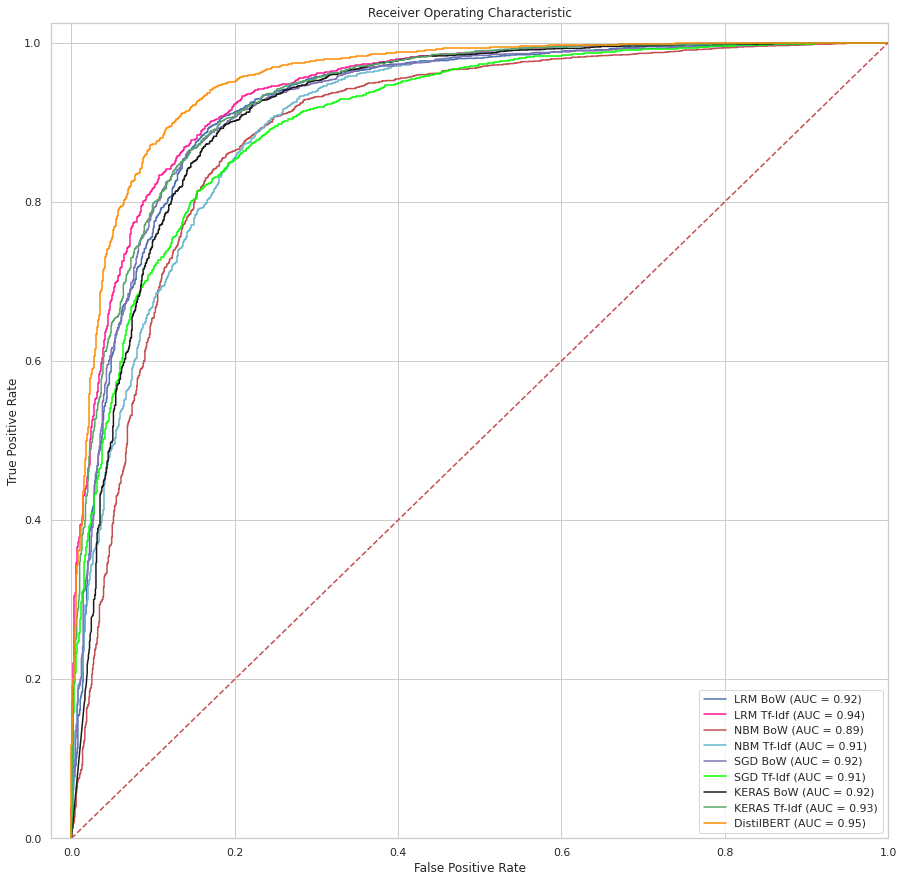

In [38]:
plt.figure(figsize=(15,15))
plt.title('Receiver Operating Characteristic')

# LRM Plots
plt.plot(fpr_lrm_bow, tpr_lrm_bow, 'b', 
         label = 'LRM BoW (AUC = %0.2f)' % lrm_auc_bow)
plt.plot(fpr_lrm_tfidf, tpr_lrm_tfidf, 'deeppink', 
         label = 'LRM Tf-Idf (AUC = %0.2f)' % lrm_auc_tfidf)

# NBM Plots
plt.plot(fpr_clf_bow, tpr_clf_bow, 'r', 
         label = 'NBM BoW (AUC = %0.2f)' % clf_auc_bow)
plt.plot(fpr_clf_tfidf, tpr_clf_tfidf, 'c', 
         label = 'NBM Tf-Idf (AUC = %0.2f)' % clf_auc_tfidf)

# SGD Plots
plt.plot(fpr_sgd_bow, tpr_sgd_bow, 'm', 
         label = 'SGD BoW (AUC = %0.2f)' % sgd_auc_bow)
plt.plot(fpr_sgd_tfidf, tpr_sgd_tfidf, 'lime', 
         label = 'SGD Tf-Idf (AUC = %0.2f)' % sgd_auc_tfidf)

# KERAS Plots
plt.plot(fpr_keras_bow, tpr_keras_bow, 'k', 
         label = 'KERAS BoW (AUC = %0.2f)' % keras_auc_bow)
plt.plot(fpr_keras_tfidf, tpr_keras_tfidf, 'g', 
         label = 'KERAS Tf-Idf (AUC = %0.2f)' % keras_auc_tfidf)

# BERT Plots
plt.plot(fpr_bert, tpr_bert, 'darkorange', 
         label = 'DistilBERT (AUC = %0.2f)' % bert_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.025, 1])
plt.ylim([0, 1.025])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

After evaluating the different models, we can see that overall high scores with most of the models. Even with only a portion of the dataset, DistilBERT produced a very high accuracy. With more resources devoted to it, it's possible for the cross-validation score of DistilBERT to surpass all the models. However, even with minimal settings, it takes a lot time to train and predict. DistilBERT may not be a viable option for this project.

KERAS was able to train within a reasonable time, but only at minimal settings. As a result, optimizing this model will be very time intensive. Luckily, even with the base model, it has a fairly good accuracy and cross-val score.

That being said, logistic regression using tf-Idf is a very close third in cross-val score and performs the best out of the supervised models. We can also see that the logistic regression model has a very good AUC curve compared to KERAS using tf-idf. An added benefit of logistic regression is that it is very fast to train and optimize. 

We decided that it would be be best to run a hybrid model using an optimized logistic regression using tf-idf and KERAS using tf-idf. Although logistic regression using BoW has the second highest cross-val score, we want diversify the model types, so we are choosing a KERAS model.

# Phase 1b: Training the Final Model

Let's begin optimizing the logisitic regression model. Since it's so fast to run, we can optimize all the variables in one run. We will use the entire training set to optimize and use the test set to evaluate the model.

In [0]:
params = {
    'penalty': ['l1', 'l2'], 
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'lbfgs'],
    'tol': np.logspace(-4, 4, 20),
    'n_jobs': [-1],
    'max_iter': [50]
}

In [40]:
%%time
# check which combination is best
lrm_opt = LogisticRegression()
grid = GridSearchCV(lrm_opt, params, n_jobs=-1, cv=3)
grid.fit(X_train_tfidf, y_train)

CPU times: user 34.6 s, sys: 3.57 s, total: 38.2 s
Wall time: 40min 35s


In [41]:
grid.best_estimator_.get_params()

{'C': 11.288378916846883,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 50,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 4.281332398719396,
 'verbose': 0,
 'warm_start': False}

It's easier to copy down the params so that we have the option to skip the optimization if we run the code in the future.

In [0]:
# Copy down the final parameters
params = {'C': 11.288378916846883,
          'class_weight': None,
          'dual': False,
          'fit_intercept': True,
          'intercept_scaling': 1,
          'l1_ratio': None,
          'max_iter': 50,
          'multi_class': 'auto',
          'n_jobs': -1,
          'penalty': 'l2',
          'random_state': None,
          'solver': 'lbfgs',
          'tol': 4.281332398719396,
          'verbose': 0,
          'warm_start': False
          }

In [43]:
# Let's run the optimized model on the test data
lrm_opt = LogisticRegression(**params)

lrm_opt.fit(X_train_tfidf, y_train)
lrm_opt_results = model_metrics2(lrm_opt, X_test_tfidf, y_test)

# Print results
print('\nLogistic Regression Model (Optimized)')
print('*'*37)
format_metrics(lrm_opt_results)


Logistic Regression Model (Optimized)
*************************************
Cross Validation Scores Using Small Training Set
[0.8791286015460296, 0.8826423049894588, 0.8664792691496838, 0.8699929725931131, 0.893183415319747, 0.8678847505270555, 0.8812368236120871, 0.8713080168776371, 0.8825597749648383, 0.8741209563994374]

Average CV = 0.8768536885979088

Classification Report Using Validation Set
              precision    recall  f1-score   support

           0       0.85      0.78      0.82      4672
           1       0.90      0.93      0.92      9555

    accuracy                           0.88     14227
   macro avg       0.88      0.86      0.87     14227
weighted avg       0.88      0.88      0.88     14227

Confusion Matrix Using Validation Set
True Positives = 8924
True Negatives= 3659
False Positives = 1013
False Negatives = 631


In [44]:
# Run unoptimized model
params = {
    'penalty': 'l2',
    'fit_intercept': True, 
    'max_iter': 50, 
    'n_jobs':-1, 
    'dual': False
}

lrm_model_old = LogisticRegression(**params)
lrm_model_old.fit(X_train_tfidf, y_train)
lrm_results_tfidf = model_metrics2(lrm_model_old, X_test_tfidf, y_test)

# Print results
print('\nLogistic Regression Model (Unoptimized)')
print('*'*39)
format_metrics(lrm_results_tfidf)


Logistic Regression Model (Unoptimized)
***************************************
Cross Validation Scores Using Small Training Set
[0.8713984539704849, 0.8643710470836261, 0.8531271960646521, 0.8524244553759662, 0.8770203794799719, 0.8685874912157414, 0.8608573436401967, 0.8572433192686357, 0.8635724331926864, 0.8656821378340366]

Average CV = 0.8634284257125998

Classification Report Using Validation Set
              precision    recall  f1-score   support

           0       0.88      0.74      0.81      4672
           1       0.88      0.95      0.92      9555

    accuracy                           0.88     14227
   macro avg       0.88      0.85      0.86     14227
weighted avg       0.88      0.88      0.88     14227

Confusion Matrix Using Validation Set
True Positives = 9100
True Negatives= 3467
False Positives = 1205
False Negatives = 455


Now let's run the KERAS model to see how it fares out with the full training set. We see that there's a dip in cross-validation score but that's to be expected.

In [45]:
# Run KERAS on training set
tfidf_keras = partial(create_keras, X_train_tfidf)

keras_model_final = KerasClassifier(
    build_fn=tfidf_keras, 
    epochs=10, 
    batch_size=1000, 
    verbose=0)

# Fit model
keras_model_final.fit(X_train_tfidf.sorted_indices(), y_train)

# Calculate results
keras_results_final = model_metrics2(keras_model_final, X_test_tfidf.sorted_indices(), y_test)

# Print results
print('\nKeras Model (Unoptimized)')
print('*'*25)
format_metrics(keras_results_final)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Keras Model (Unoptimized)
*************************
Cross Validation Scores Using Small Training Set
[0.8664792776107788, 0.8721011877059937, 0.8706957101821899, 0.8552353978157043, 0.8629655838012695, 0.8685874938964844, 0.8847505450248718, 0.8776371479034424, 0.8734177350997925, 0.8713080286979675]

Average CV = 0.8703178107738495

Classification Report Using Validation Set
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      4672
           1       0.89      0.93      0.91      9555

    accuracy                           0.88     14227
   macro avg       0.87      0.85      0.86     14227
weighted avg       0.88      0.88      0.88     14227

Confusion Matrix Using Validation Set
True Positives = 8896
True Negatives= 3595
False Positives = 1077
False Negatives = 659


In [46]:
# let's output the models
path = '/content/gdrive/My Drive/Final_Capstone/'

with open(path + 'lrm_model.pkl', 'wb') as f:
  f.write(pickle.dumps(lrm_opt))

keras_model_final.model.save(path + 'keras_model.tf', 'wb+')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Final_Capstone/keras_model.tf/assets


# Phase 1 Conclusion

In conclusion, although DistilBert has the potentital to be very accurate as a model, it was way too expensive to run. That being said, simpler models performed with very high accuracy and are adequate for this project. Not only does it take a lot of resources to train, it also takes a lot of time to predict. As a result, it is not a viable candidate for this project. 

For the optimization process, we were able to improve the logistic regression model a bit. In particular, we saw an increase in true negatives with a slight dip in true positives. Although we could not optimize the KERAS model due to time constraints, an optimized KERAS model could be developed if we had the resources. It could provide some improvement to the final model, but it would be marginal at best.

Another way we could have improved the project is by running the model using more than two labels. One combination is using 5 labels (1 to 5 stars). We could have also used 3 labels (1-2 stars, 3 stars, and 4-5 stars). These combinations, however, come with a loss of accuracy. This is due to the fact that differences between 1, 2, & 3 star reviews is very hard to determine as they are generally very arbitrary with very small nuiances. This was shown with the word clouds. However, this lack of accuracy could be compensated with better deep learning models and more deep learning optimization. 

We can see that while the hybrid model is not perfect, it does a fairly accurate job at detecting sentiment. In the next phase, we will demonstrate how we would use this on unlabelled reviews (yelp tips).